# Aprendizaje no supervisado; Clusterizacion de Clientes , K MEANS 

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from functools import reduce
from kmodes.kprototypes import KPrototypes

#Fetaure Selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


#Model Evaluation
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Cargamos data set
olist_orders = pd.read_csv('./input-online/olist_orders_dataset.csv')
olist_products = pd.read_csv('./input-online/olist_products_dataset.csv')
olist_items = pd.read_csv('./input-online/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./input-online/olist_customers_dataset.csv')
olist_payments = pd.read_csv('./input-online/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./input-online/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./input-online/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./input-online/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./input-online/product_category_name_translation.csv')

In [ ]:
# merge 

all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')


all_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116576,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,invoiced,2018-07-11 22:27:32,2018-07-11 22:45:43,NaN,NaN,2018-07-20 00:00:00,1.0,5b668636d65ddf4e4109c6d8fb13ea56,7c5b05cbdb5542049f38d90d7815b97d,2018-07-16 22:45:43,44.99,7.58,1,credit_card,1,52.57,633538990df4c5fb118483fe

## PREPROCESAMIENTO DE DATOS 



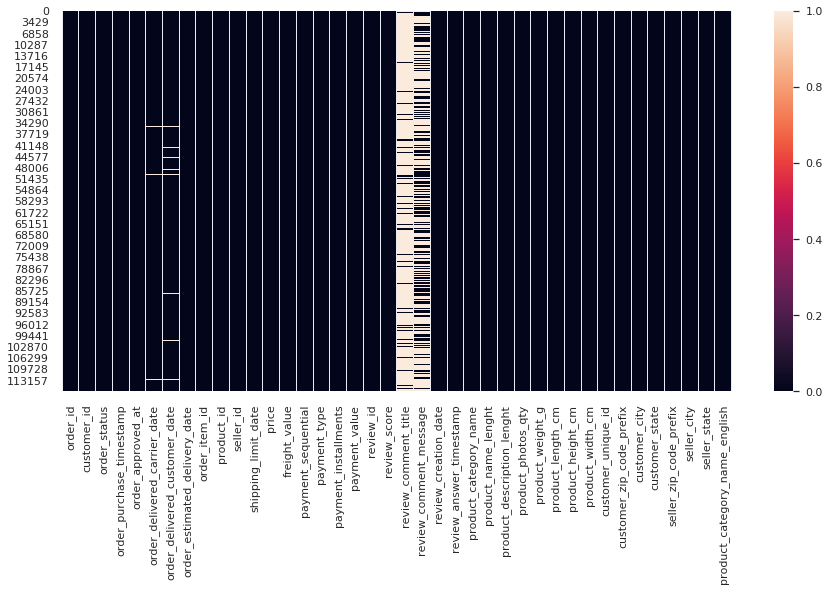

In [ ]:
# Chequeamos Nan

plt.figure(figsize=(15,7))
sns.set_style("dark",  {'figure.facecolor': 'white'})
sns.heatmap(all_data.isnull())


In [ ]:
nullcount = {col:all_data[col].isnull().sum() for col in all_data.columns}
nullcount

{'order_id': 0,
 'customer_id': 0,
 'order_status': 0,
 'order_purchase_timestamp': 0,
 'order_approved_at': 14,
 'order_delivered_carrier_date': 1213,
 'order_delivered_customer_date': 2515,
 'order_estimated_delivery_date': 0,
 'order_item_id': 0,
 'product_id': 0,
 'seller_id': 0,
 'shipping_limit_date': 0,
 'price': 0,
 'freight_value': 0,
 'payment_sequential': 0,
 'payment_type': 0,
 'payment_installments': 0,
 'payment_value': 0,
 'review_id': 0,
 'review_score': 0,
 'review_comment_title': 102585,
 'review_comment_message': 66703,
 'review_creation_date': 0,
 'review_answer_timestamp': 0,
 'product_category_name': 0,
 'product_name_lenght': 0,
 'product_description_lenght': 0,
 'product_photos_qty': 0,
 'product_weight_g': 1,
 'product_length_cm': 1,
 'product_height_cm': 1,
 'product_width_cm': 1,
 'customer_unique_id': 0,
 'customer_zip_code_prefix': 0,
 'customer_city': 0,
 'customer_state': 0,
 'seller_zip_code_prefix': 0,
 'seller_city': 0,
 'seller_state': 0,
 'product_ca

In [ ]:
# Vemos qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [ ]:
#dulicados

all_data.duplicated().any()

False

In [ ]:
# Cambiamos el tipo de datos en la columna de fecha 

date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#Creeamos una columna de mes_orden para la exploración de datos

all_data['Month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')

In [ ]:
all_data[['Month_order','order_purchase_timestamp']].head()

,Month_order,order_purchase_timestamp
0,2017-10,2017-10-02 10:56:33
1,2017-10,2017-10-02 10:56:33
2,2017-10,2017-10-02 10:56:33
3,2017-08,2017-08-15 18:29:31
4,2017-08,2017-08-02 18:24:47


In [ ]:
# Elija entradas que van desde 01-2017 hasta 08-2018
#Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 y después del 08-2018
# basado en datos de compra / order_purchase_timestamp

start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [ ]:
# Gestiona entradas vacías en la columna order_approved_at

missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('='*50)
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

# tomamos la mediana porque hay quienes aprueban directamente desde el momento en que ordena, algunos son de hasta 60 días
add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at']= all_data['order_approved_at'].replace(np.nan, add_1)

count                    116178
mean     0 days 10:27:08.897923
std      0 days 21:53:11.220121
min             0 days 00:00:00
25%             0 days 00:12:56
50%             0 days 00:20:46
75%      0 days 14:54:27.750000
max            60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:46


/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Gestiona entradas vacías en la columna order_approved_at
all_data[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43
4,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01


In [ ]:
# Gestión de entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('='*50)
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

# Tomamos la mediana porque algunos barcos están dentro de las 21 horas del tiempo acordado, algunos hasta 107 días
add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date']= all_data['order_delivered_carrier_date'].replace(np.nan, add_2)

count                    115016
mean     2 days 19:36:08.343613
std      3 days 11:05:42.705027
min         -172 days +18:44:38
25%             0 days 21:12:37
50%      1 days 20:05:56.500000
75%      3 days 14:45:47.750000
max           107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:05:56.500000


/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Gestión de entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('='*50)
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

# tomamos la mediana porque hay un tiempo de entrega de -17 días, lo que significa que es atípico, también hay un tiempo de entrega de hasta 205 días
add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date']= all_data['order_delivered_customer_date'].replace(np.nan, add_3)

count                     113726
mean      9 days 05:09:53.148923
std       8 days 15:22:27.173498
min           -17 days +21:41:31
25%              4 days 01:44:35
50%              7 days 01:35:06
75%      11 days 22:31:48.500000
max            205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:35:06


/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Manejar las columnas review_comment_title y review_comment_message
#Porque el número de entradas en blanco es muy grande e imposible de completar porque no hay variables que puedan
# usado para calcularlo. Porque este es el comentario y el título del comentario
# Luego eliminaremos la columna

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [ ]:
# Entrega de entrada vacía en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
#Porque solo hay 1, entonces lo dejamos caer
all_data = all_data.dropna()

In [ ]:
# Compruebamos si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [ ]:
# Ajuste el tipo de datos con los datos de entrada
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

## Igenieria de variables 




In [ ]:
#Creamos una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta
# artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [ ]:
#Creamos una columna order_delivery_time para ver cuánto tiempo se requiere el tiempo de envío para cada pedido
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [ ]:
#Creamos una columna order_time_accuracy para ver si desde el tiempo estimado hasta que algo sea apropiado o tarde
# Si el valor es + positivo, entonces es más rápido hasta que, si es 0, está justo a tiempo, pero si es negativo, llega tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [ ]:
#Creamos una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [ ]:
#Creamos una columna review_send_time para averiguar cuánto tiempo se envió la encuesta de satisfacción después de recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [ ]:
#Creamos una columna review_answer_time para averiguar cuánto tiempo llevará completar una revisión después de
# envió una encuesta de satisfacción del cliente.
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [ ]:
# Combinamos las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
# con una nueva columna, volumen_producto
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

In [ ]:
# Creamos una nueva variable para ver el tiempo desde que se realizo la compra 

all_data['time_since_purchase'] = all_data['order_purchase_timestamp'].max() - all_data['order_purchase_timestamp']

In [ ]:
pd.set_option('display.max_columns', None)
all_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,Month_order,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,review_send_time,review_answer_time,product_volume,time_since_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12 03:43:48,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,00:10:42,02:34:47,1 days 03:43:48,1976.0,331 days 04:04:04
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12 03:43:48,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,00:10:42,02:34:47,1 days 03:43:48,1976.0,331 days 04:04:04
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12 03:43:48,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,00:10:42,02:34:47,1 days 03:43:48,1976.0,331 days 04:04:04
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,2017-08-19,2017-08-20 15:16:36,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares,2017-08,2 days 20:15:12,0 days 23:16:10,9 days 09:15:17,01:35:45,09:15:17,1 days 15:16:36,1976.0,378 days 20:31:06
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,2017-08-08,2017-08-08 23:26:23,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares,2017-08,5 days 00:05:14,3 days 00:54:18,7 days 05:29:59,00:18:28,05:29:59,0 days 23:26:23,1976.0,391 days 20:35:50


## Tratamiento de date time features 

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116191 entries, 0 to 116580
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       116191 non-null  object         
 1   customer_id                    116191 non-null  object         
 2   order_status                   116191 non-null  object         
 3   order_purchase_timestamp       116191 non-null  datetime64[ns] 
 4   order_approved_at              116191 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   116191 non-null  datetime64[ns] 
 6   order_delivered_customer_date  116191 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  116191 non-null  datetime64[ns] 
 8   order_item_id                  116191 non-null  int64          
 9   product_id                     116191 non-null  object         
 10  seller_id                      116191 non-null  object  

In [ ]:
# Eliminamos las variables datetime, ya que no seran utiles para el modelo de clustering 

all_data = all_data.drop(['order_approved_at','order_estimated_delivery_date' \
                          , 'order_delivered_carrier_date', 'review_creation_date', 'review_answer_timestamp' ,\
                          'order_delivered_customer_date', 'shipping_limit_date'], axis=1)


In [ ]:
# Transformamos las variables tipo timedelta en float


all_data['order_process_time'] = all_data['order_process_time']/ np.timedelta64(1, 'D')
all_data['order_accuracy_time'] = all_data['order_accuracy_time']/ np.timedelta64(1, 'D')
all_data['order_delivery_time'] = all_data['order_delivery_time']/ np.timedelta64(1, 'D')
all_data['order_approved_time'] = all_data['order_approved_time']/ np.timedelta64(1, 'D')
all_data['review_send_time'] = all_data['review_send_time']/ np.timedelta64(1, 'D')
all_data['review_answer_time'] = all_data['review_answer_time']/ np.timedelta64(1, 'D')
all_data['time_since_purchase'] = all_data['time_since_purchase']/ np.timedelta64(1, 'D')




In [ ]:
all_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,Month_order,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,review_send_time,review_answer_time,product_volume,time_since_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8.436574,6.062650,7.107488,0.007431,0.107488,1.155417,1976.0,331.169491
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8.436574,6.062650,7.107488,0.007431,0.107488,1.155417,1976.0,331.169491
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,2017-10,8.436574,6.062650,7.107488,0.007431,0.107488,1.155417,1976.0,331.169491
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares,2017-08,2.843889,0.969560,9.385613,0.066493,0.385613,1.636528,1976.0,378.854931
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,utilidades_domesticas,40,268,4,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares,2017-08,5.003634,3.037708,7.229155,0.012824,0.229155,0.976655,1976.0,391.858218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116576,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,invoiced,2018-07-11 22:27:32,1,5b668636d65ddf4e4109c6d8fb13ea56,7c5b05cbdb5542049f38d90d7815b97d,44.99,7.58,1,credit_card,1,52.57,633538990df4c5fb118483feb8557347,1,livros_importados,53,568,1,300.0,25.0,2.0,30.0,f84487fed78baf25458828c99a2daa5d,3402,sao paulo,SP,5201,sao paulo,SP,books_imported,2018-07,8.916128,7.066042,-0.851916,0.012627,1.148084,2.546331,1500.0,48.689641
116577,1dbff949801376b8795a093d31cfe205,0cbd2df3d6e9d8b1eaf5cfefc44886bc,delivered,2018-05-16 14:50:54,1,90797f195eb7bb9dae050697a25f35ce,7c5b05cbdb5542049f38d90d7815b97d,58.99,7.39,1,credit_card,1,66.38,fbcc01887a5e5adacd0f4bb2a57e5d12,5,livros_importados,48,459,1,300.0,33.0,2.0,23.0,1de8fb735d8252498d9a2f82a68c57e0,9411,ribeirao pires,SP,5201,sao paulo,SP,books_imported,2018-05,5.099468,3.211204,6.281852,0.019306,8.281852,0.439398,1518.0,105.006748
116578,6775b950cdc4da0ce39b261032f92c84,c4d135422be0d4333f506acde

## Transformamos el data frame para obtener a una unica instancia por cliente.

*utilizando la funcion group by tomamos medidas de resumen por cliente para las variables existentes, y contruimos nuevas variables.

In [ ]:
# Agrupamos aplicando la funcion .size para contar el numero de compras por cliente 
# creamos nueva variable con total de compras por clientes 'total_purchases'

total_purchases= all_data.groupby('customer_unique_id').size().to_frame(name= 'total_purchases').reset_index()

total_purchases


,customer_unique_id,total_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,2
93786,fffea47cd6d3cc0a88bd621562a9d061,1
93787,ffff371b4d645b6ecea244b27531430a,1
93788,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
# Creamos una nueva variable con el total de categorias diferentes en las compras realizadas por cada cliente
# 'total_purchase_category'

total_purchase_category = all_data[['customer_unique_id','product_category_name_english']]

total_purchase_category = pd.get_dummies(total_purchase_category, columns=['product_category_name_english']).groupby('customer_unique_id').sum()

total_purchase_category[total_purchase_category != 0] = 1

total_purchase_category = total_purchase_category.sum(axis = 1).to_frame(name= 'total_purchase_category').reset_index()

total_purchase_category

,customer_unique_id,total_purchase_category
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,1
93786,fffea47cd6d3cc0a88bd621562a9d061,1
93787,ffff371b4d645b6ecea244b27531430a,1
93788,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
# Creamos una nueva variable, calculando el promedio del tiempo entre compra y compra por cliente
# 'time_btw_purchase'

time_btw_purchase = all_data[['customer_unique_id','order_purchase_timestamp']]

time_btw_purchase['time_since_last_purchase'] = time_btw_purchase.sort_values(['customer_unique_id','order_purchase_timestamp']).groupby('customer_unique_id')['order_purchase_timestamp'].diff()

time_btw_purchase['time_since_last_purchase'] = time_btw_purchase['time_since_last_purchase']/ np.timedelta64(1, 'D')

time_btw_purchase['time_since_last_purchase'] = time_btw_purchase['time_since_last_purchase'].fillna(0)

time_btw_purchase =time_btw_purchase.groupby('customer_unique_id').agg(np.mean)

time_btw_purchase['time_since_last_purchase']

/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/juanfi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    0.0
0000b849f77a49e4a4ce2b2a4ca5be3f    0.0
0000f46a3911fa3c0805444483337064    0.0
0000f6ccb0745a6a4b88665a16c9f078    0.0
0004aac84e0df4da2b147fca70cf8255    0.0
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    0.0
fffea47cd6d3cc0a88bd621562a9d061    0.0
ffff371b4d645b6ecea244b27531430a    0.0
ffff5962728ec6157033ef9805bacc48    0.0
ffffd2657e2aad2907e67c3e9daecbeb    0.0
Name: time_since_last_purchase, Length: 93790, dtype: float64

In [ ]:
# Agrupamos, por id del cliente, las variables continuas donde la media va a ser la medida de resumen de las compras del cliente


agrupated_by_mean =all_data.groupby('customer_unique_id')[["price", "freight_value",\
                                                           "payment_value", 'review_score', 'product_photos_qty','product_description_lenght', \
                                                           'order_process_time', 'order_delivery_time', 'order_accuracy_time', 'order_approved_time' \
                                                           ,'review_send_time', 'review_answer_time', 'product_volume' ]].agg(np.mean)

agrupated_by_mean = agrupated_by_mean.add_suffix('_mean')

agrupated_by_mean

,price_mean,freight_value_mean,payment_value_mean,review_score_mean,product_photos_qty_mean,product_description_lenght_mean,order_process_time_mean,order_delivery_time_mean,order_accuracy_time_mean,order_approved_time_mean,review_send_time_mean,review_answer_time_mean,product_volume_mean
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,129.90,12.00,141.90,5.0,1.0,236.0,6.411227,4.521262,4.132905,0.010313,0.132905,4.572778,7616.0
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,8.29,27.19,4.0,1.0,635.0,3.285590,1.239375,4.248125,0.301586,0.248125,0.937095,5148.0
0000f46a3911fa3c0805444483337064,69.00,17.22,86.22,3.0,3.0,177.0,25.731759,23.069641,1.389734,0.000000,0.389734,1.055370,43750.0
0000f6ccb0745a6a4b88665a16c9f078,25.99,17.63,43.62,4.0,5.0,1741.0,20.037083,19.051921,11.108970,0.013611,0.108970,1.012396,1045.0
0004aac84e0df4da2b147fca70cf8255,180.00,16.89,196.89,5.0,3.0,794.0,13.141134,11.136644,7.035463,0.014699,0.035463,4.937211,528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,785.00,248.71,2067.42,5.0,1.0,478.5,27.514861,12.846215,26.609722,0.010185,0.609722,4.472280,251625.0
fffea47cd6d3cc0a88bd621562a9d061,64.89,19.69,84.58,4.0,2.0,506.0,30.097500,19.250914,2.063657,0.005833,0.063657,5.494433,32076.0
ffff371b4d645b6ecea244b27531430a,89.90,22.56,112.46,5.0,5.0,716.0,14.872083,14.111424,29.468704,0.009352,0.468704,2.627326,3315.0


In [ ]:
# Agrupamos, por id del cliente, las variables categoricas donde la moda va a ser la medida de resumen de las compras del cliente

# como puede haber mas de una categoria con multiple modas, seleccionamos la primera que sale

agrupated_by_mode =all_data.groupby('customer_unique_id')[['payment_sequential','payment_type',\
                     'customer_zip_code_prefix', 'seller_zip_code_prefix',\
                                                          'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name_english']].agg(pd.Series.mode)

agrupated_by_mode = agrupated_by_mode.add_suffix('_mode')
agrupated_by_mode


,payment_type_mode,customer_city_mode,customer_state_mode,seller_city_mode,seller_state_mode,product_category_name_english_mode
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,credit_card,cajamar,SP,piracicaba,SP,bed_bath_table
0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,osasco,SP,sao paulo,SP,health_beauty
0000f46a3911fa3c0805444483337064,credit_card,sao jose,SC,campo limpo paulista,SP,stationery
0000f6ccb0745a6a4b88665a16c9f078,credit_card,belem,PA,sao paulo,SP,telephony
0004aac84e0df4da2b147fca70cf8255,credit_card,sorocaba,SP,jacarei,SP,telephony
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,credit_card,sanharo,PE,sao paulo,SP,health_beauty
fffea47cd6d3cc0a88bd621562a9d061,credit_card,feira de santana,BA,laranjal paulista,SP,baby
ffff371b4d645b6ecea244b27531430a,credit_card,sinop,MT,belo horizonte,MG,auto


In [ ]:
# Agrupamos, por id del cliente, las variables categoricas donde la suma de las instancias va a ser la medida de resumen de las compras del cliente


agrupated_by_sum =all_data.groupby('customer_unique_id')['price'].agg(np.sum).rename('total_spend').reset_index()



agrupated_by_sum 


,customer_unique_id,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
93786,fffea47cd6d3cc0a88bd621562a9d061,64.89
93787,ffff371b4d645b6ecea244b27531430a,89.90
93788,ffff5962728ec6157033ef9805bacc48,115.00


In [ ]:

# Agrupamos, por id del cliente, las variables categoricas donde el max valor de las instancias va a ser la medida de resumen de las compras del cliente

agrupated_by_max=all_data.groupby('customer_unique_id')[['price','payment_sequential',\
                                                        'freight_value','payment_installments',]].agg(np.max)

agrupated_by_max =agrupated_by_max.rename(columns={'price': 'max_spend','payment_sequential':'max_payment_sequential', 'freight_value':'max_freight_value','payment_installments':'max_payment_installments'})

agrupated_by_max

,max_spend,max_payment_sequential,max_freight_value,max_payment_installments
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,12.00,8
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,8.29,1
0000f46a3911fa3c0805444483337064,69.00,1,17.22,8
0000f6ccb0745a6a4b88665a16c9f078,25.99,1,17.63,4
0004aac84e0df4da2b147fca70cf8255,180.00,1,16.89,6
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,890.00,1,258.28,10
fffea47cd6d3cc0a88bd621562a9d061,64.89,1,19.69,1
ffff371b4d645b6ecea244b27531430a,89.90,1,22.56,1


In [ ]:

# Agrupamos, por id del cliente, las variables categoricas donde el min valor de las instancias va a ser la medida de resumen de las compras del cliente

agrupated_by_min=all_data.groupby('customer_unique_id')[['time_since_purchase']].agg(np.min)
agrupated_by_min

,time_since_purchase
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,111.169560
0000b849f77a49e4a4ce2b2a4ca5be3f,114.159144
0000f46a3911fa3c0805444483337064,536.746921
0000f6ccb0745a6a4b88665a16c9f078,320.771481
0004aac84e0df4da2b147fca70cf8255,287.802025
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446.750012
fffea47cd6d3cc0a88bd621562a9d061,261.786586
ffff371b4d645b6ecea244b27531430a,567.966215


### Unimos todas las nuevas columnas en un unico data frame

In [ ]:
dfs = [total_purchases, total_purchase_category, time_btw_purchase, agrupated_by_mean, \
      agrupated_by_mode, agrupated_by_min, agrupated_by_max, agrupated_by_sum]

In [ ]:


df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['customer_unique_id'],
                                            how='outer'), dfs)

df_merged

,customer_unique_id,total_purchases,total_purchase_category,time_since_last_purchase,price_mean,freight_value_mean,payment_value_mean,review_score_mean,product_photos_qty_mean,product_description_lenght_mean,order_process_time_mean,order_delivery_time_mean,order_accuracy_time_mean,order_approved_time_mean,review_send_time_mean,review_answer_time_mean,product_volume_mean,payment_type_mode,customer_city_mode,customer_state_mode,seller_city_mode,seller_state_mode,product_category_name_english_mode,time_since_purchase,max_spend,max_payment_sequential,max_freight_value,max_payment_installments,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,0.0,129.90,12.00,141.90,5.0,1.0,236.0,6.411227,4.521262,4.132905,0.010313,0.132905,4.572778,7616.0,credit_card,cajamar,SP,piracicaba,SP,bed_bath_table,111.169560,129.90,1,12.00,8,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,0.0,18.90,8.29,27.19,4.0,1.0,635.0,3.285590,1.239375,4.248125,0.301586,0.248125,0.937095,5148.0,credit_card,osasco,SP,sao paulo,SP,health_beauty,114.159144,18.90,1,8.29,1,18.90
2,0000f46a3911fa3c0805444483337064,1,1,0.0,69.00,17.22,86.22,3.0,3.0,177.0,25.731759,23.069641,1.389734,0.000000,0.389734,1.055370,43750.0,credit_card,sao jose,SC,campo limpo paulista,SP,stationery,536.746921,69.00,1,17.22,8,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,0.0,25.99,17.63,43.62,4.0,5.0,1741.0,20.037083,19.051921,11.108970,0.013611,0.108970,1.012396,1045.0,credit_card,belem,PA,sao paulo,SP,telephony,320.771481,25.99,1,17.63,4,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,1,0.0,180.00,16.89,196.89,5.0,3.0,794.0,13.141134,11.136644,7.035463,0.014699,0.035463,4.937211,528.0,credit_card,sorocaba,SP,jacarei,SP,telephony,287.802025,180.00,1,16.89,6,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,2,1,0.0,785.00,248.71,2067.42,5.0,1.0,478.5,27.514861,12.846215,26.609722,0.010185,0.609722,4.472280,251625.0,credit_card,sanharo,PE,sao paulo,SP,health_beauty,446.750012,890.00,1,258.28,10,1570.00
93786,fffea47cd6d3cc0a88bd621562a9d061,1,1,0.0,64.89,19.69,84.58,4.0,2.0,506.0,30.097500,19.250914,2.063657,0.005833,0.063657,5.494433,32076.0,credit_card,feira de santana,BA,laranjal paulista,SP,baby,261.786586,64.89,1,19.69,1,64.89
93787,ffff371b4d645b6ecea244b27531430a,1,1,0.0,89.90,22.56,112.46,5.0,5.0,716.0,14.872083,14.111424,29.468704,0.009352,0.468704,2.627326,3315.0,credit_card,sinop,MT,belo horizonte,MG,auto,567.966215,89.90,1,22.56,1,89.90
93788,ffff5962728ec6157033ef9805bacc48,1,1,0.0,115.00,18.69,133.69,5.0,3.0,591.0,11.858854,10.798218,13.503866,0.028542,0.503866,2.636343,4480.0,credit_card,bom jesus do norte,ES,ribeirao preto,SP,watches_gifts,118.988148,115.00,1,18.69,5,115.00


In [ ]:
# Cuando realizamos el group by y tomamos como medida de resumen la moda, en algunas 
# instancias se guardaron como lista los valores de las modas con igual ocurrencia.

#Seleccionamos el primer valor para esos casos

df_merged["payment_type_mode"] = df_merged["payment_type_mode"].str.split("(").str[0]
df_merged["customer_state_mode"] = df_merged["customer_state_mode"].str.split("(").str[0]
df_merged["product_category_name_english_mode"] = df_merged["product_category_name_english_mode"].str.split("(").str[0]
df_merged["customer_city_mode"] = df_merged["customer_city_mode"].str.split("(").str[0]
df_merged["seller_city_mode"] = df_merged["seller_city_mode"].str.split("(").str[0]
df_merged["seller_state_mode"] = df_merged["seller_state_mode"].str.split("(").str[0]

## EDA del nuevo df despues del group by 

In [ ]:
## Importamos funcion de preprocesamiento 


import funcion_ouliers

In [ ]:
cambiar(df_merged)

,customer_unique_id,total_purchases,total_purchase_category,time_since_last_purchase,price_mean,freight_value_mean,payment_value_mean,review_score_mean,product_photos_qty_mean,product_description_lenght_mean,order_process_time_mean,order_delivery_time_mean,order_accuracy_time_mean,order_approved_time_mean,review_send_time_mean,review_answer_time_mean,product_volume_mean,payment_type_mode,customer_city_mode,customer_state_mode,seller_city_mode,seller_state_mode,product_category_name_english_mode,time_since_purchase,max_spend,max_payment_sequential,max_freight_value,max_payment_installments,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,1.0,0.0,129.90,12.000000,141.900000,5.0,1.0,236.0,6.411227,4.521262,4.132905,0.010313,0.132905,4.572778,7616.0,credit_card,cajamar,SP,piracicaba,SP,bed_bath_table,111.169560,129.90,1.0,12.00,8.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,1.0,0.0,18.90,8.290000,27.190000,4.0,1.0,635.0,3.285590,1.239375,4.248125,0.301586,0.248125,0.937095,5148.0,credit_card,osasco,SP,sao paulo,SP,health_beauty,114.159144,18.90,1.0,8.29,1.0,18.90
2,0000f46a3911fa3c0805444483337064,1.0,1.0,0.0,69.00,17.220000,86.220000,3.0,3.0,177.0,25.731759,23.069641,1.389734,0.005197,0.389734,1.055370,43750.0,credit_card,sao jose,SC,campo limpo paulista,SP,stationery,536.746921,69.00,1.0,17.22,8.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,1.0,0.0,25.99,17.630000,43.620000,4.0,5.0,1741.0,20.037083,19.051921,11.108970,0.013611,0.108970,1.012396,1045.0,credit_card,belem,PA,sao paulo,SP,telephony,320.771481,25.99,1.0,17.63,4.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,1.0,1.0,0.0,180.00,16.890000,196.890000,5.0,3.0,794.0,13.141134,11.136644,7.035463,0.014699,0.035463,4.937211,627.0,credit_card,sorocaba,SP,jacarei,SP,telephony,287.802025,180.00,1.0,16.89,6.0,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,2.0,1.0,0.0,594.00,60.740057,672.370172,5.0,1.0,478.5,27.514861,12.846215,26.609722,0.010185,0.609722,4.472280,78750.0,credit_card,sanharo,PE,sao paulo,SP,health_beauty,446.750012,599.00,1.0,62.08,10.0,690.00
93786,fffea47cd6d3cc0a88bd621562a9d061,1.0,1.0,0.0,64.89,19.690000,84.580000,4.0,2.0,506.0,30.097500,19.250914,2.063657,0.005833,0.063657,5.494433,32076.0,credit_card,feira de santana,BA,laranjal paulista,SP,baby,261.786586,64.89,1.0,19.69,1.0,64.89
93787,ffff371b4d645b6ecea244b27531430a,1.0,1.0,0.0,89.90,22.560000,112.460000,5.0,5.0,716.0,14.872083,14.111424,29.241079,0.009352,0.468704,2.627326,3315.0,credit_card,sinop,MT,belo horizonte,MG,auto,546.169121,89.90,1.0,22.56,1.0,89.90
93788,ffff5962728ec6157033ef9805bacc48,1.0,1.0,0.0,115.00,18.690000,133.690000,5.0,3.0,591.0,11.858854,10.798218,13.503866,0.028542,0.503866,2.636343,4480.0,credit_card,bom jesus do norte,ES,ribeirao preto,SP,watches_gifts,118.988148,115.00,1.0,18.69,5.0,115.00


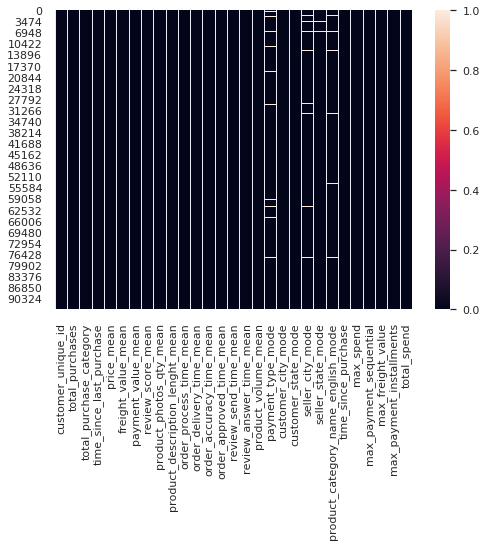

In [ ]:
sns.heatmap(df_merged.isnull())

In [ ]:
#asignamos a los Nan el valor de la moda para cada columna 

for column in df_merged.columns:
    df_merged[column].fillna(df_merged[column].mode()[0], inplace=True)

### Tratamiento de variables categoricas 

In [ ]:
# Reducimos el numero de categorias en 'Categoria de productos'

product_category= df_merged['product_category_name_english_mode'].value_counts(normalize=True)


other=product_category[18:]
other=other.index.tolist()

df_merged.loc[df_merged['product_category_name_english_mode'].isin(other),'product_category_name_english_mode']='other'

In [ ]:
# Reducimos el numero de categorias para 'seller_state_mode'

seller_state= df_merged['seller_state_mode'].value_counts(normalize=True)


other=seller_state[5:]
other=other.index.tolist()

df_merged.loc[df_merged['seller_state_mode'].isin(other),'seller_state_mode']='other'

In [ ]:
# Reducimos el numero de categorias para 'customer_state_mode'

customer_state= df_merged['customer_state_mode'].value_counts(normalize=True)


other=customer_state[5:]
other=other.index.tolist()

df_merged.loc[df_merged['customer_state_mode'].isin(other),'customer_state_mode']='other'

In [ ]:
# Creamos una nueva variable que indique si los clientes compran local o en otro estado 

df_merged['where_they_shop'] = ''

df_merged.loc[df_merged['customer_state_mode'] != df_merged["seller_state_mode"],"where_they_shop"] = "other_state"
df_merged.loc[df_merged['customer_state_mode'] == df_merged["seller_state_mode"],"where_they_shop"] = "local"

In [ ]:
# Creamos una copia de este df para analisis posteriores

df_merged_copy = df_merged.copy()

In [ ]:
df_merged_copy

,customer_unique_id,total_purchases,total_purchase_category,time_since_last_purchase,price_mean,freight_value_mean,payment_value_mean,review_score_mean,product_photos_qty_mean,product_description_lenght_mean,order_process_time_mean,order_delivery_time_mean,order_accuracy_time_mean,order_approved_time_mean,review_send_time_mean,review_answer_time_mean,product_volume_mean,payment_type_mode,customer_city_mode,customer_state_mode,seller_city_mode,seller_state_mode,product_category_name_english_mode,time_since_purchase,max_spend,max_payment_sequential,max_freight_value,max_payment_installments,total_spend,where_they_shop
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,1.0,0.0,129.90,12.00000,141.90000,5.0,1.0,236.0,6.411227,4.521262,4.132905,0.010313,0.132905,4.572778,7616.0,credit_card,cajamar,SP,piracicaba,SP,bed_bath_table,111.169560,129.90,1.0,12.00,8.0,129.90,local
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,1.0,0.0,18.90,8.29000,27.19000,4.0,1.0,635.0,3.285590,1.239375,4.248125,0.301586,0.248125,0.937095,5148.0,credit_card,osasco,SP,sao paulo,SP,health_beauty,114.159144,18.90,1.0,8.29,1.0,18.90,local
2,0000f46a3911fa3c0805444483337064,1.0,1.0,0.0,69.00,17.22000,86.22000,3.0,3.0,177.0,25.731759,23.069641,1.389734,0.005197,0.389734,1.055370,43750.0,credit_card,sao jose,other,campo limpo paulista,SP,stationery,536.746921,69.00,1.0,17.22,8.0,69.00,other_state
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,1.0,0.0,25.99,17.63000,43.62000,4.0,5.0,1741.0,20.037083,19.051921,11.108970,0.013611,0.108970,1.012396,1045.0,credit_card,belem,other,sao paulo,SP,telephony,320.771481,25.99,1.0,17.63,4.0,25.99,other_state
4,0004aac84e0df4da2b147fca70cf8255,1.0,1.0,0.0,180.00,16.89000,196.89000,5.0,3.0,794.0,13.141134,11.136644,7.035463,0.014699,0.035463,4.937211,627.0,credit_card,sorocaba,SP,jacarei,SP,telephony,287.802025,180.00,1.0,16.89,6.0,180.00,local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93785,fffcf5a5ff07b0908bd4e2dbc735a684,2.0,1.0,0.0,594.00,60.74275,672.37825,5.0,1.0,478.5,27.514861,12.846215,26.609722,0.010185,0.609722,4.472280,78750.0,credit_card,sanharo,other,sao paulo,SP,health_beauty,446.750012,599.00,1.0,62.08,10.0,690.00,other_state
93786,fffea47cd6d3cc0a88bd621562a9d061,1.0,1.0,0.0,64.89,19.69000,84.58000,4.0,2.0,506.0,30.097500,19.250914,2.063657,0.005833,0.063657,5.494433,32076.0,credit_card,feira de santana,other,laranjal paulista,SP,baby,261.786586,64.89,1.0,19.69,1.0,64.89,other_state
93787,ffff371b4d645b6ecea244b27531430a,1.0,1.0,0.0,89.90,22.56000,112.46000,5.0,5.0,716.0,14.872083,14.111424,29.241210,0.009352,0.468704,2.627326,3315.0,credit_card,sinop,other,belo horizonte,MG,auto,546.169159,89.90,1.0,22.56,1.0,89.90,other_state
93788,ffff5962728ec6157033ef9805bacc48,1.0,1.0,0.0,115.00,18.69000,133.69000,5.0,3.0,591.0,11.858854,10.798218,13.503866,0.028542,0.503866,2.636343,4480.0,credit_card,bom jesus do norte,other,ribeirao preto,SP,watches_gifts,118.988148,115.00,1.0,18.69,5.0,115.00,other_state


# Exploracion de variables 

In [ ]:
#Creamos una funcion para plotear un boxplot y un histograma

def hist_box_plot(df,feature, fig_num):
    sns.set(color_codes = 'Blue', style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
    filtered = df.loc[~np.isnan(df[feature]), feature]
    sns.boxplot(filtered, ax = ax1, color = 'steelblue') # boxplot
    sns.distplot(filtered, kde=True, hist=True, kde_kws={'linewidth': 1}, color = 'steelblue', ax = ax2) # histogram
    plt.show()

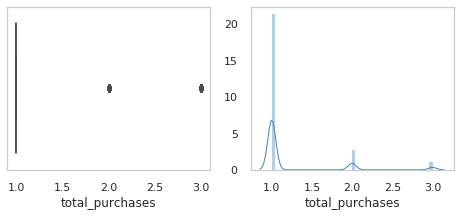

/home/juanfi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


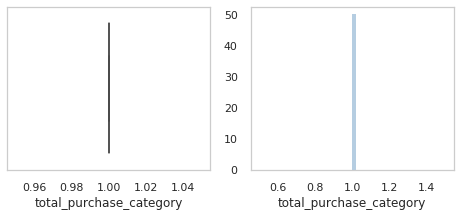

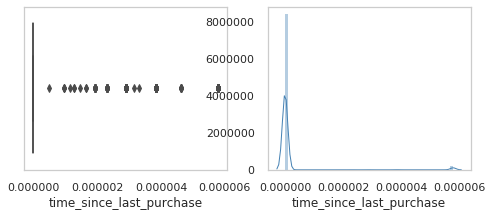

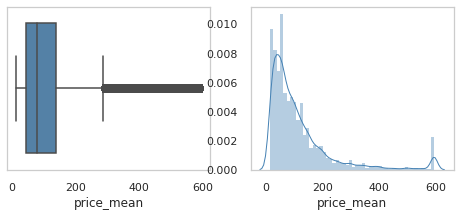

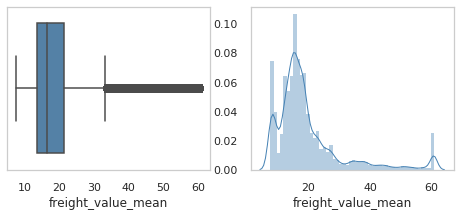

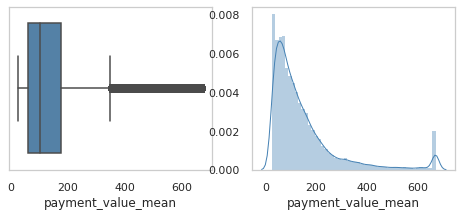

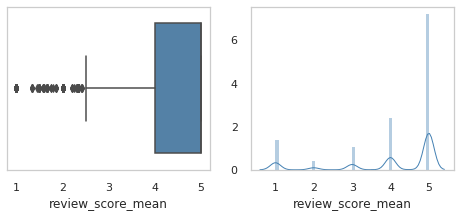

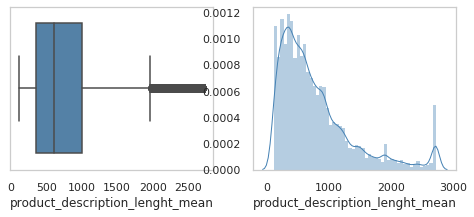

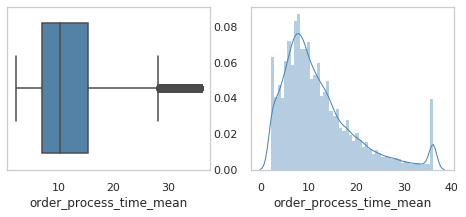

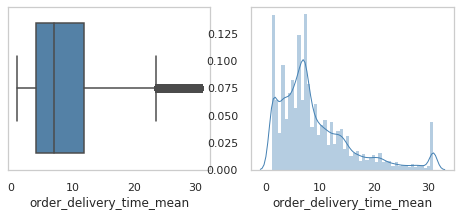

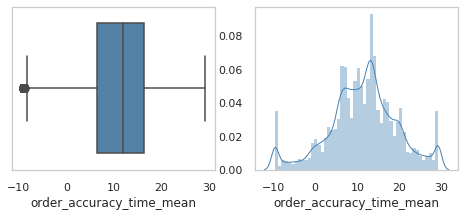

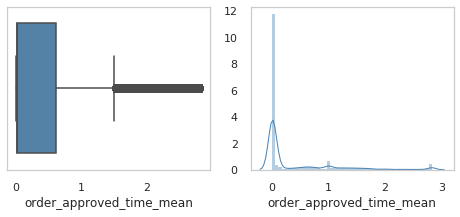

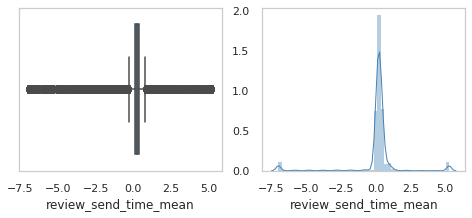

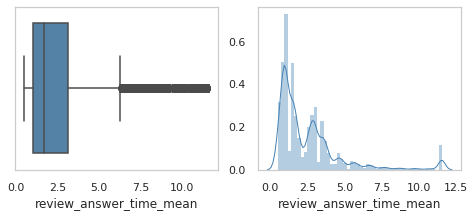

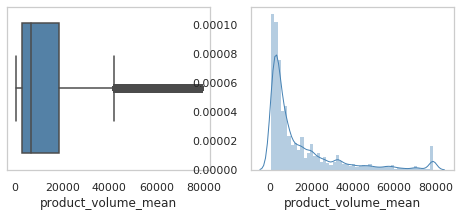

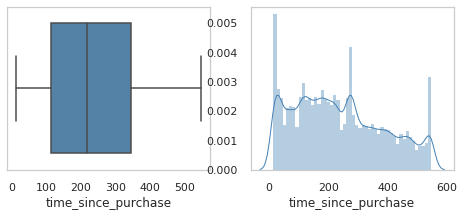

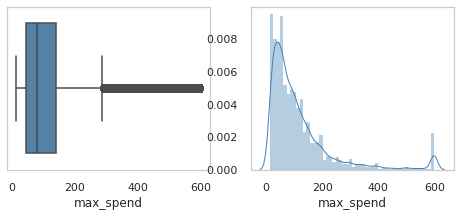

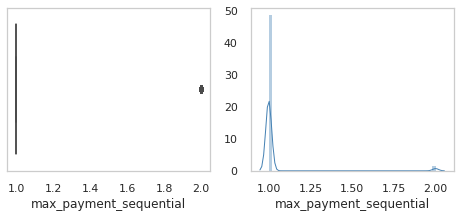

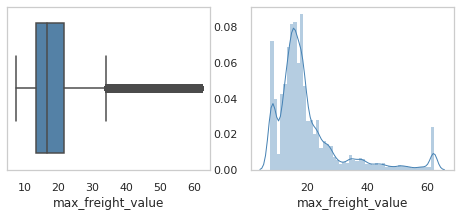

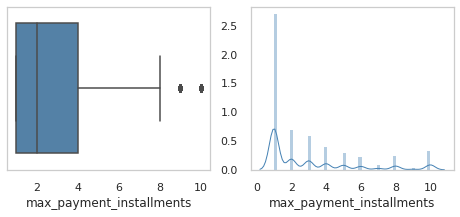

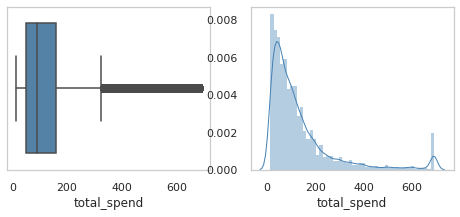

In [ ]:
fig_num = 1        
for col in df_merged.select_dtypes(include=[np.number]).columns:
    if col in  ['total_purchases','total_purchase_category', 'time_since_last_purchase','review_score_mean', 'price_mean','freight_value_mean','payment_value_mean','order_process_time_mean','max_payment_installments',\
               'product_description_lenght_mean','product_volume_mean','time_since_purchase', 'total_spend','max_spend', 'max_payment_sequential', 'max_freight_value', \
              'total_spend','order_process_time_mean','order_delivery_time_mean','order_accuracy_time_mean','order_approved_time_mean','review_send_time_mean','review_answer_time_mean']:
        hist_box_plot(df_merged,col, fig_num)
        fig_num = fig_num + 1

In [ ]:
# Creamos una funcion para plotear un countplot para variables categoricas 
def count_plot(df,feature):
    sns.set(color_codes = 'Blue', style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig = plt.subplots(figsize=(15,7))
    sns.countplot(x=feature, data=df, color = 'steelblue', order = df[feature].value_counts().index) # countplot
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

In [ ]:
# Filter categorical variables
num_cols = df_merged._get_numeric_data().columns
cols = df_merged.columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['product_category_name_english_mode',
 'customer_state_mode',
 'payment_type_mode',
 'customer_unique_id',
 'seller_city_mode',
 'customer_city_mode',
 'seller_state_mode']

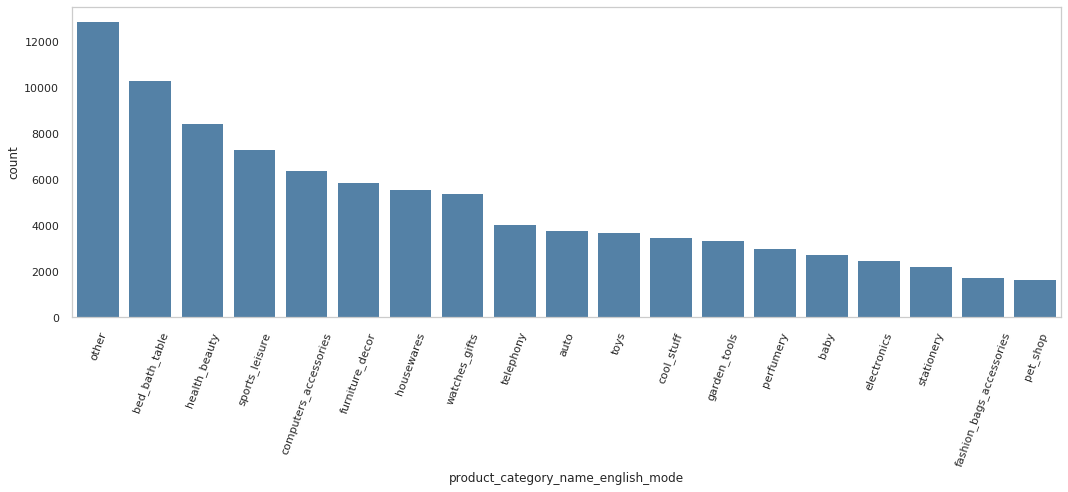

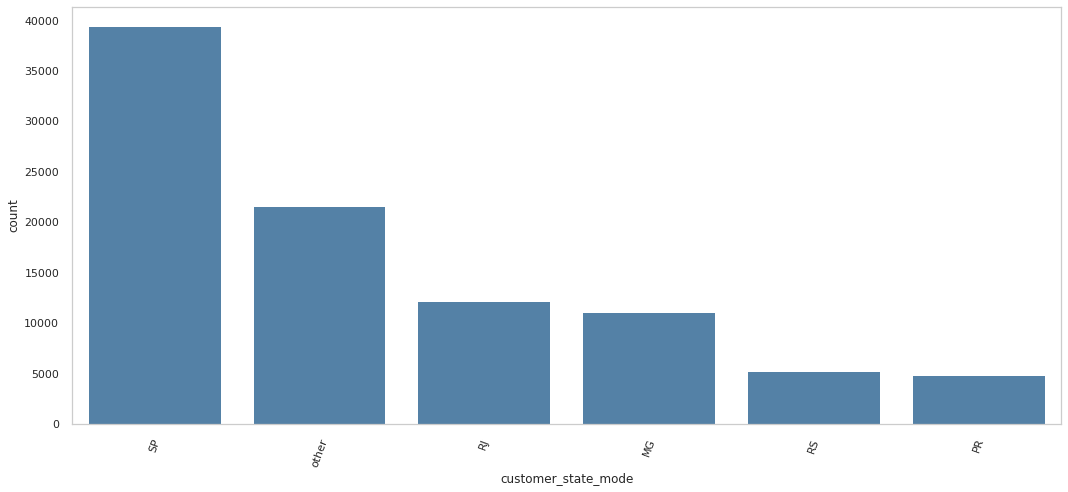

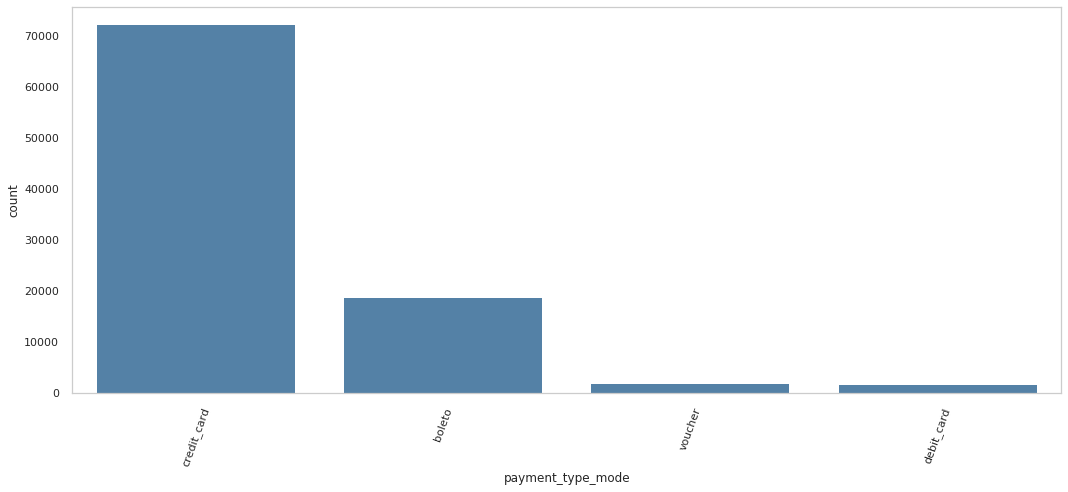

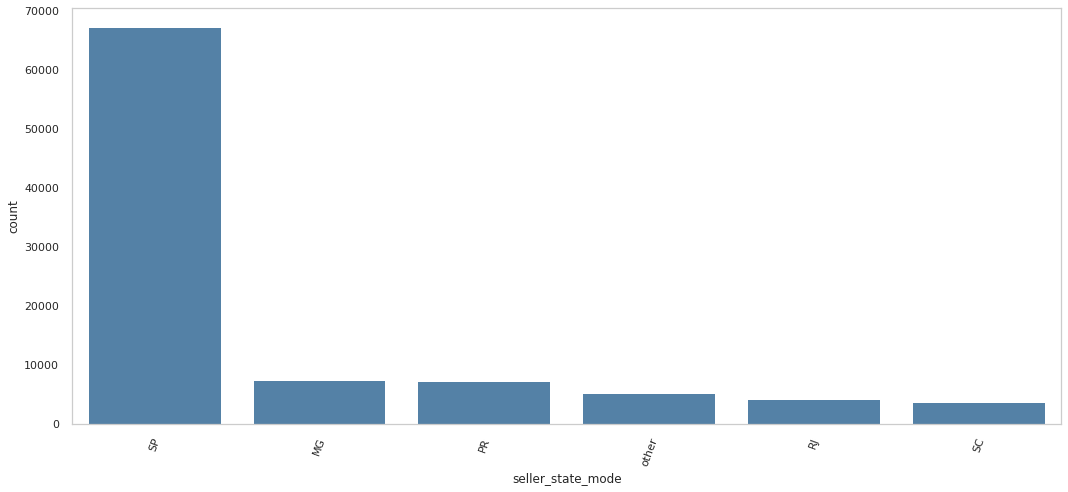

In [ ]:
for col in cat_cols:
    if col in ['payment_type_mode','product_category_name_english_mode','seller_state_mode', 'customer_state_mode']:
        count_plot(df_merged,col)
        
       

# Escalado de las variables numericas 

In [ ]:
# Escalamos las variables numericas poder clusterizar 


Num_features=df_merged.select_dtypes(include=[np.number]).columns
df_merged[Num_features]=preprocessing.MinMaxScaler().fit_transform(df_merged[Num_features])
df_merged.head()

,customer_unique_id,total_purchases,total_purchase_category,time_since_last_purchase,price_mean,freight_value_mean,payment_value_mean,review_score_mean,product_description_lenght_mean,order_process_time_mean,order_delivery_time_mean,order_accuracy_time_mean,order_approved_time_mean,review_send_time_mean,review_answer_time_mean,product_volume_mean,payment_type_mode,customer_city_mode,customer_state_mode,seller_city_mode,seller_state_mode,product_category_name_english_mode,time_since_purchase,max_spend,max_payment_sequential,max_freight_value,max_payment_installments,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.199841,0.083141,0.179346,1.00,0.045035,0.124233,0.117861,0.352835,0.001810,0.581023,0.368670,0.089461,credit_card,cajamar,SP,piracicaba,SP,bed_bath_table,0.182361,0.198120,0.0,0.080764,0.777778,0.170345
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.008465,0.013355,0.001889,0.75,0.198614,0.031958,0.008265,0.355805,0.104854,0.590411,0.040478,0.057870,credit_card,osasco,SP,sao paulo,SP,health_beauty,0.187980,0.008376,0.0,0.012665,0.000000,0.005925
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.094843,0.181330,0.093209,0.50,0.022325,0.694615,0.737271,0.282130,0.000000,0.601950,0.051155,0.551989,credit_card,sao jose,other,campo limpo paulista,SP,stationery,0.982290,0.094017,0.0,0.176579,0.777778,0.080136
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.020689,0.189042,0.027306,0.75,0.624326,0.526497,0.603102,0.532643,0.002977,0.579073,0.047275,0.005351,credit_card,belem,other,sao paulo,SP,telephony,0.576335,0.020496,0.0,0.184104,0.333333,0.016427
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.286219,0.175123,0.264416,1.00,0.259815,0.322914,0.338777,0.427648,0.003362,0.573084,0.401568,0.000000,credit_card,sorocaba,SP,jacarei,SP,telephony,0.514365,0.283761,0.0,0.170521,0.555556,0.244556


In [ ]:
df_merged.dtypes

customer_unique_id                     object
total_purchases                       float64
total_purchase_category               float64
time_since_last_purchase              float64
price_mean                            float64
freight_value_mean                    float64
payment_value_mean                    float64
review_score_mean                     float64
product_description_lenght_mean       float64
order_process_time_mean               float64
order_delivery_time_mean              float64
order_accuracy_time_mean              float64
order_approved_time_mean              float64
review_send_time_mean                 float64
review_answer_time_mean               float64
product_volume_mean                   float64
payment_type_mode                      object
customer_city_mode                     object
customer_state_mode                    object
seller_city_mode                       object
seller_state_mode                      object
product_category_name_english_mode

# PCA

In [ ]:
# Relizamos un analisis de componentes principales para reducir la dimensionalidad de los 
# datos cuantitativos.

# Seleccionamos variables numerica para pca 

Data_pca = df_merged[['total_purchases', 'time_since_last_purchase', 'review_score_mean', 'total_spend']].copy()


print (Data_pca.dtypes)

total_purchases                       float64
freight_value_mean                    float64
review_score_mean                     float64
payment_type_mode                      object
customer_state_mode                    object
seller_state_mode                      object
product_category_name_english_mode     object
time_since_purchase                   float64
total_spend                           float64
dtype: object


In [ ]:


from sklearn.decomposition import PCA
pca = PCA(n_components=3, whiten=True)
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance


print(np.cumsum((pca.explained_variance_ratio_)))


#plt.plot(np.cumsum((pca.explained_variance_ratio_)))

[0.33481532 0.57003536 0.77261063]


In [ ]:
# Construimos un df con las variables creadas en el pca 
principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.shape

(93790, 3)





# Clusterizaciòn; K means

In [ ]:
principalDf_sample = principalDf.sample(2000,random_state=41)
X_sample = principalDf_sample
X_sample

,principal component 1,principal component 2,principal component 3
40460,-0.625100,1.490361,0.357020
57836,0.742945,1.169711,-0.610020
15506,0.642213,0.007195,0.980809
24707,-0.444456,1.420415,1.057530
34756,2.153879,1.029183,-1.327991
...,...,...,...
27322,-0.032115,-0.185832,-0.626760
56182,2.451276,-0.087185,0.449973
60696,-0.102614,-0.631576,-1.100987
65452,1.369708,-0.775154,-1.318447


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

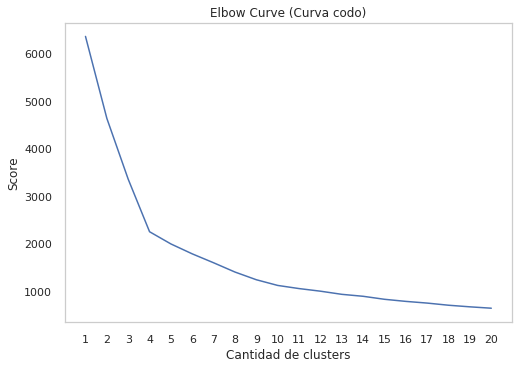

In [ ]:

# Eleccion del K optimo  

rangos = range(1, 21) 
kmeans = [None] * 20
for i in rangos:
    kmeans[i-1] = KMeans(n_clusters=i)
    
score = [None] * 20

for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(X_sample).inertia_) 
    
plt.plot(rangos,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(rangos)
plt.show()    


In [ ]:
# Convertimos el dataset en una matriz
X = principalDf.values
X

array([[-0.76601611, -0.72982027, -0.3904885 ],
       [-0.09942988, -0.65536428, -1.07289383],
       [ 0.77678959,  2.01762615, -0.49793527],
       ...,
       [-0.64505761,  2.06369321,  0.1158927 ],
       [-0.74617297, -0.72726156, -0.2493908 ],
       [-0.70221711,  1.73059946, -0.27331108]])

In [ ]:
kmeans= KMeans(n_clusters=4, n_init=40,tol = 0.01)



In [ ]:
#AJUSTAMOS EL MODELO
kmeans.fit(X)

#print("model" , kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=40, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.01, verbose=0)

In [ ]:
kmeans.inertia_

102101.63656278493

In [ ]:
kmeans_predicted = kmeans.predict(X)

In [ ]:
kmeans.cluster_centers_

array([[-0.49828779, -0.73115632, -0.31871474],
       [ 0.22105475, -0.25610577,  2.11066224],
       [-0.4110123 ,  1.05222712, -0.11775832],
       [ 1.82660692, -0.03099715, -0.54675702]])

In [ ]:
clusters = kmeans.labels_
clusters

array([0, 0, 2, ..., 2, 0, 2], dtype=int32)

In [ ]:
df_merged_copy['cluster'] = pd.Series(kmeans_predicted, index=df_merged_copy.index)

### Estudio de clusters 

### Caracteristicas de cada grupo de clientes : 

Cluster 0 : 'ESPORDICOS' Compraron solo una vez hace tiempo. Gastaron poco y estan conformes con su compra, pero no volvieron a consumir.

Cluster 1 : 'FIDELIZADOS'  Son clientes fijos, compran seguido y gastan mucho. Estan conformes y pagan en cuotas.

Cluster 2 : 'NUEVOS' Son nuevos clientes que gastaron poco y solo compraron una vez hace poco tiempo.

Cluster 3 : 'DISCONFORMES' Son clientes disconformes. Compraron una vez o mas y puntuaron muy mal, recibieron su compra tarde. Hay una tendencia a no comprar màs.


In [1]:
df_merged_copy.cluster.value_counts(normalize = True)

NameError: ignored

In [2]:

df_merged_copy.loc[(df_merged_copy.cluster == 0),'cluster']='Esporadicos'
df_merged_copy.loc[(df_merged_copy.cluster == 1),'cluster']='Fidelizados'
df_merged_copy.loc[(df_merged_copy.cluster == 2),'cluster']='Nuevos'
df_merged_copy.loc[(df_merged_copy.cluster == 3),'cluster']='Disconformes'

df_merged_copy

NameError: ignored

In [ ]:
df_merged_sample = df_merged_copy.sample(2000,random_state=41)

In [ ]:
df_merged_sample

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x="cluster", data=df_merged_copy)

### forma de pago

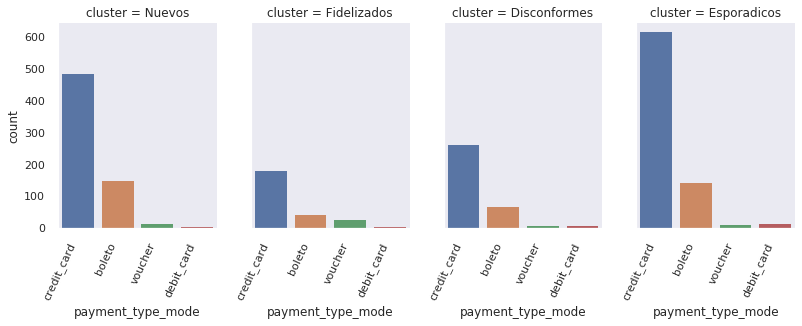

In [ ]:
g = sns.catplot(x="payment_type_mode", col="cluster",
                data=df_merged_sample, kind="count",
                height=4, aspect=.7);
g.set_xticklabels(rotation=65, horizontalalignment='right')


### Categoria de producto que compran 

<Figure size 1440x360 with 0 Axes>

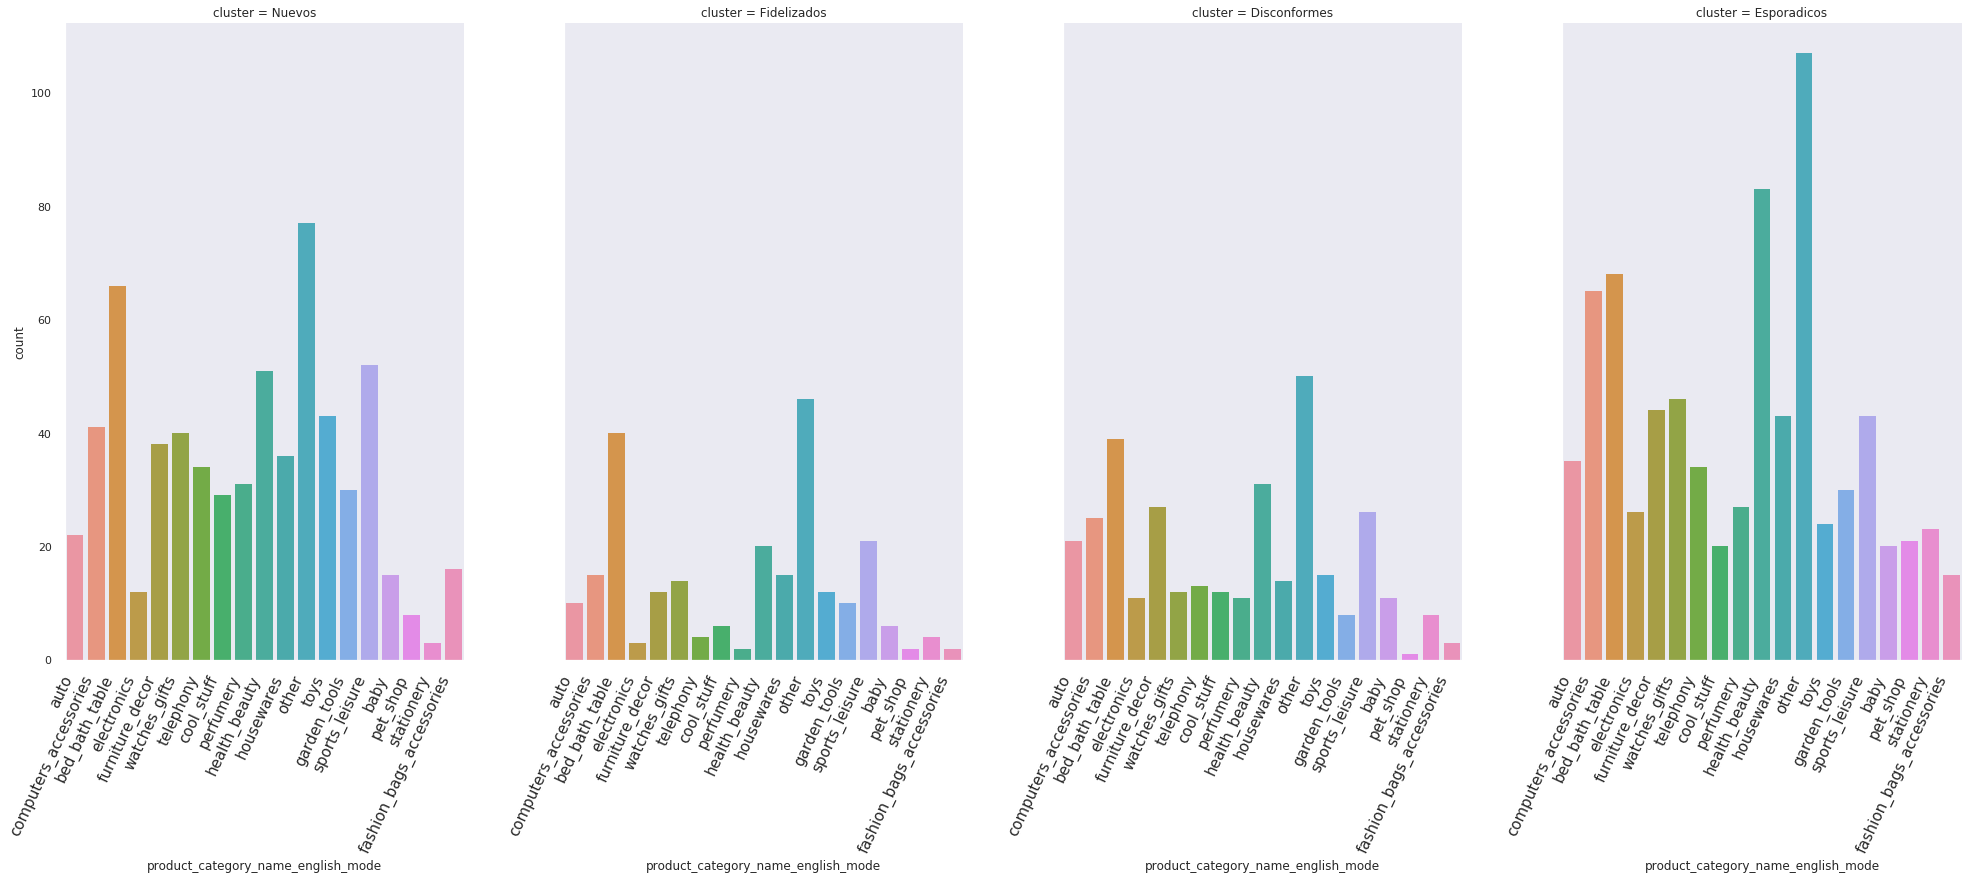

In [ ]:

plt.figure(figsize=(20,5))
g = sns.catplot(x="product_category_name_english_mode", col="cluster",
                data=df_merged_sample, kind="count",
                height=10, aspect=.7, );
g.set_xticklabels(rotation=65, horizontalalignment='right',size=15)



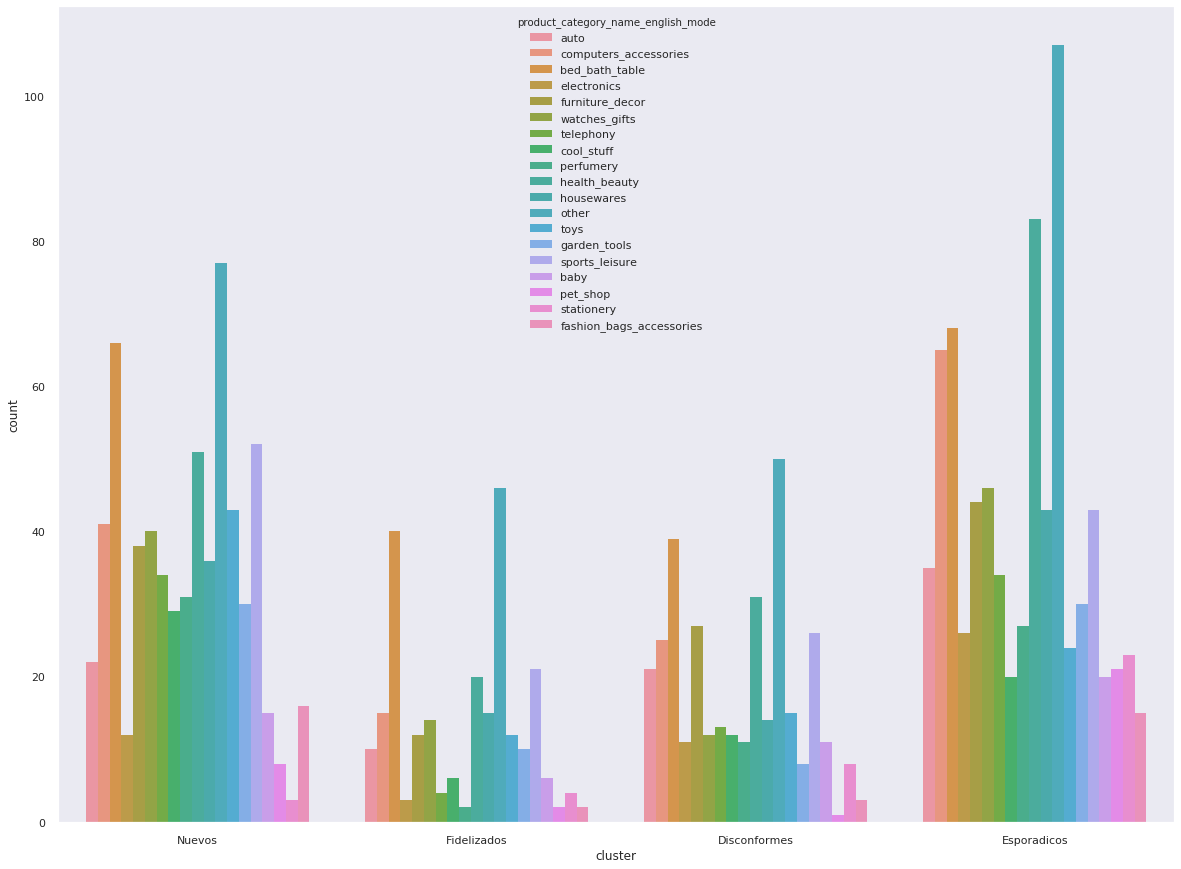

In [ ]:


plt.figure(figsize=(20,15))
ax = sns.countplot(x="cluster", hue="product_category_name_english_mode", data=df_merged_sample)
#ax.set_xticklabels(rotation=65, horizontalalignment='right',size=5)


### Localizacion geografica de los clientes y de los vendedores a quienes compran.

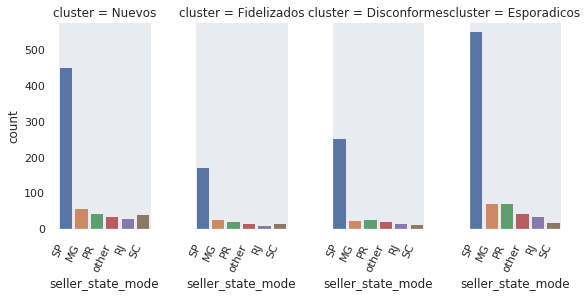

In [ ]:
g = sns.catplot(x="seller_state_mode", col="cluster",
                data=df_merged_sample, kind="count",
                height=4, aspect=.5);
g.set_xticklabels(rotation=65, horizontalalignment='right')

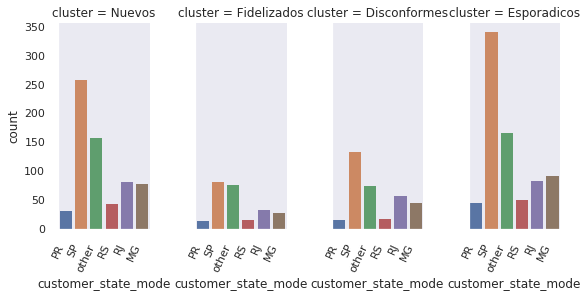

In [ ]:

g = sns.catplot(x="customer_state_mode", col="cluster",
                data=df_merged_sample, kind="count",
                height=4, aspect=.5);
g.set_xticklabels(rotation=65, horizontalalignment='right')

### Numero de compras

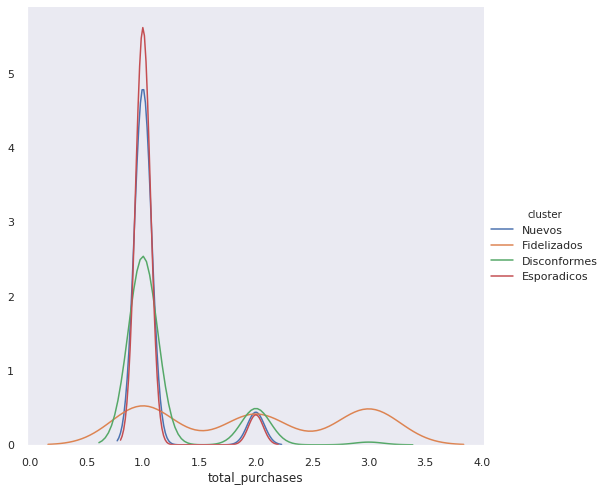

In [ ]:
# Numero de compras de los clientes en cada cluster

sns.FacetGrid(df_merged_sample, hue="cluster", height=7).map(sns.kdeplot, 'total_purchases').add_legend()


plt.show()

### Cuanto gastan 

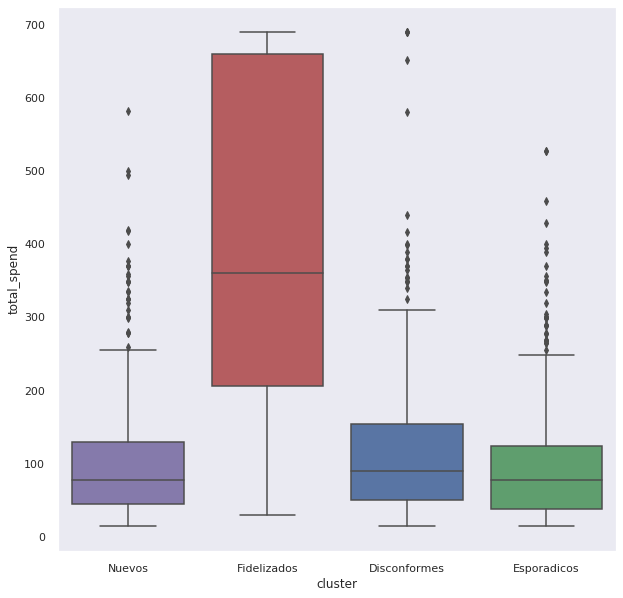

In [ ]:
# Total historico

plt.figure(figsize=(10,10))
my_pal = {'Esporadicos': "g", 'Fidelizados': "r", 'Nuevos':"m", 'Disconformes':'b'}

ax = sns.boxplot("cluster", y="total_spend", data=df_merged_sample, palette=my_pal)




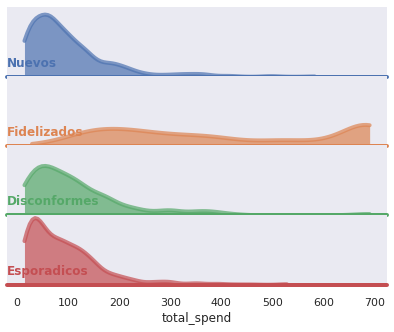

In [ ]:
ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "total_spend", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "total_spend")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

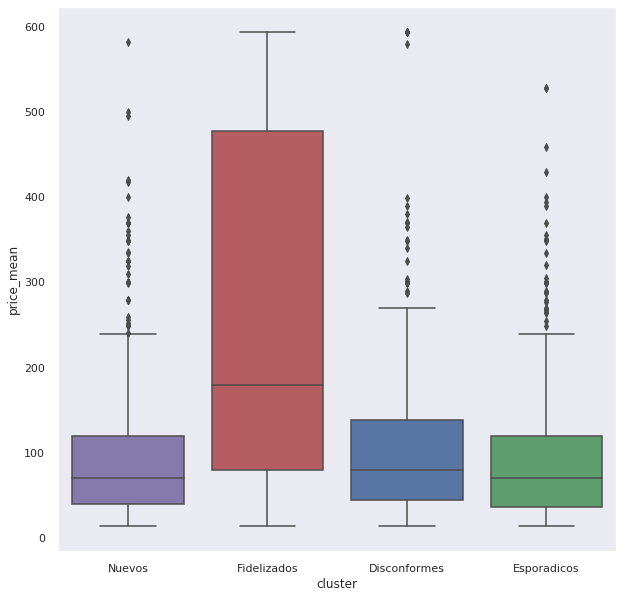

In [ ]:
# Costo promedio de cada producto comprado

plt.figure(figsize=(10,10))
my_pal = {'Esporadicos': "g", 'Fidelizados': "r", 'Nuevos':"m", 'Disconformes':'b'}
ax = sns.boxplot("cluster", y="price_mean", data=df_merged_sample, palette=my_pal)


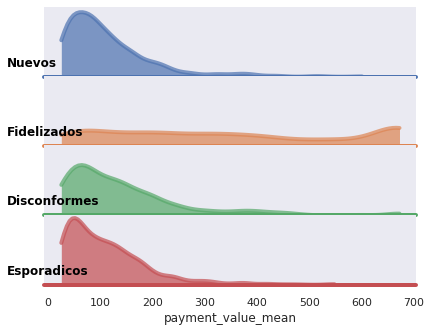

In [ ]:
ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "payment_value_mean", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "payment_value_mean")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

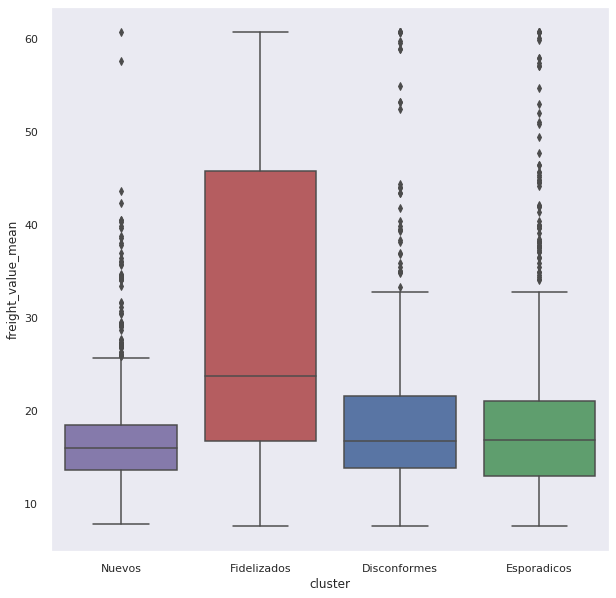

In [ ]:
# Promedio de gasto de envio


plt.figure(figsize=(10,10))
my_pal = {'Esporadicos': "g", 'Fidelizados': "r", 'Nuevos':"m", 'Disconformes':'b'}
ax = sns.boxplot("cluster", y="freight_value_mean", data=df_merged_sample, palette=my_pal)


### Como puntean las compras 

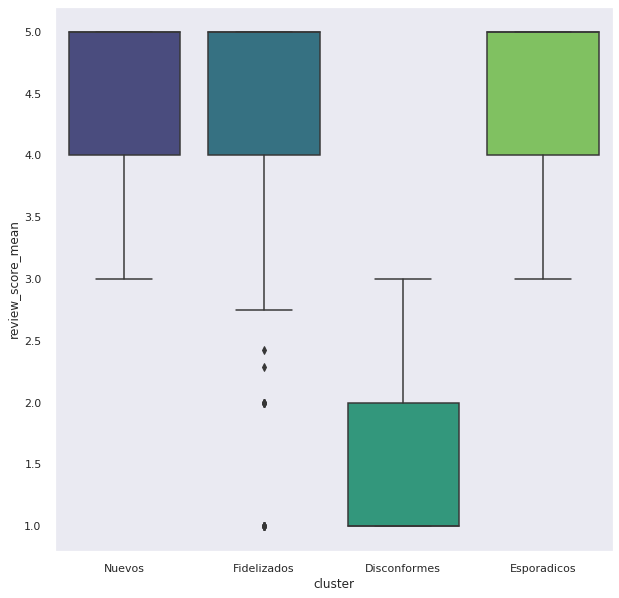

In [ ]:



plt.figure(figsize=(10,10))
ax = sns.boxplot("cluster", y="review_score_mean", data=df_merged_sample, palette="viridis")


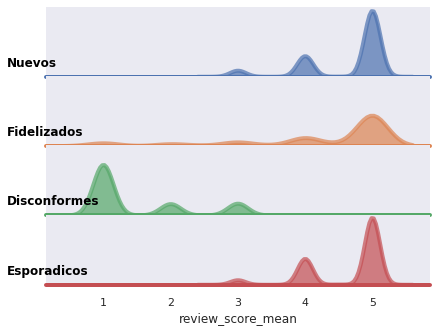

In [ ]:

ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "review_score_mean", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "review_score_mean")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)




### volumen de los productos comprados

In [3]:



plt.figure(figsize=(10,10))
ax = sns.boxplot("cluster", y="product_volume_mean", data=df_merged_sample, palette="coolwarm")


NameError: ignored

### Pagos en cuotas

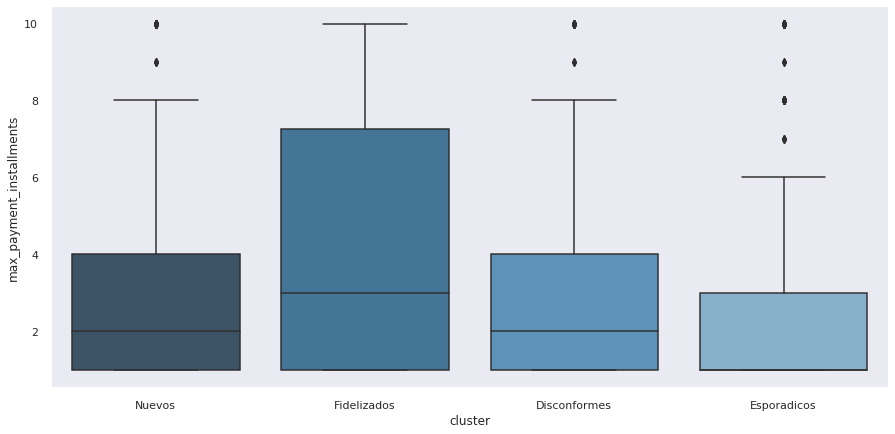

In [ ]:
# Maximo numero de cuotas pagas en una compra

plt.figure(figsize=(15,7))
ax = sns.boxplot("cluster", y="max_payment_installments", data=df_merged_sample, palette="Blues_d")


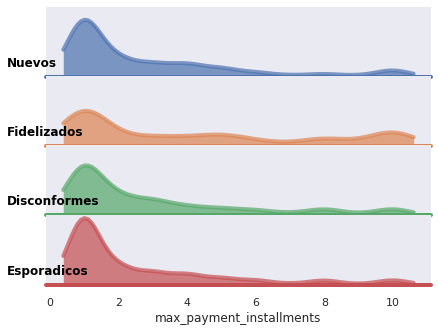

In [ ]:


ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "max_payment_installments", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "max_payment_installments")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)



### Tiempo desde la ultima compra

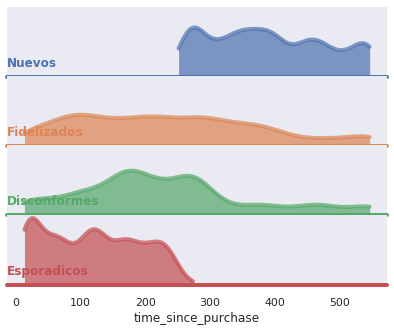

In [ ]:

ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "time_since_purchase", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "time_since_purchase")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)


### tiempo de envio de review

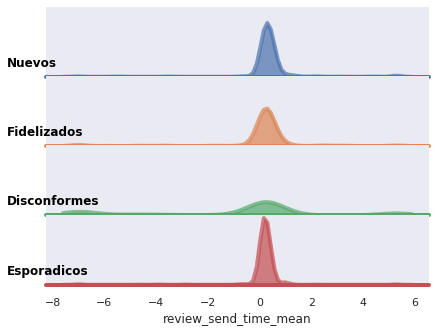

In [ ]:


ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "review_send_time_mean", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "review_send_time_mean")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)

###  tiempo de precisión del pedido

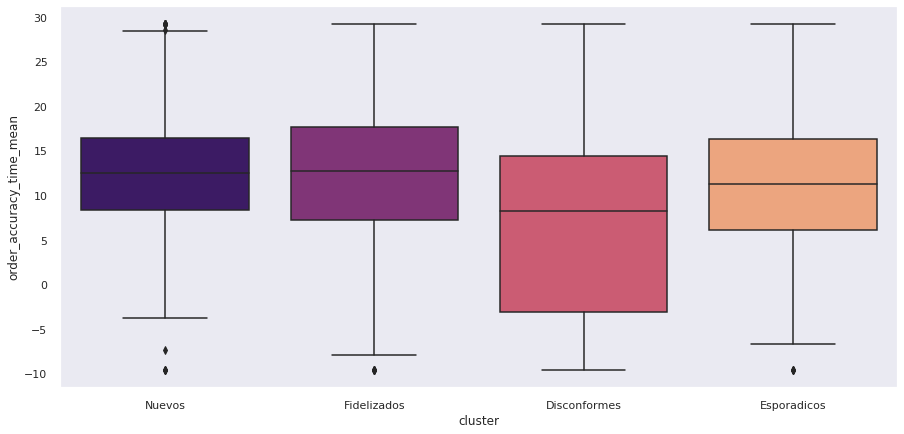

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.boxplot("cluster", y="order_accuracy_time_mean", data=df_merged_sample, palette="magma")


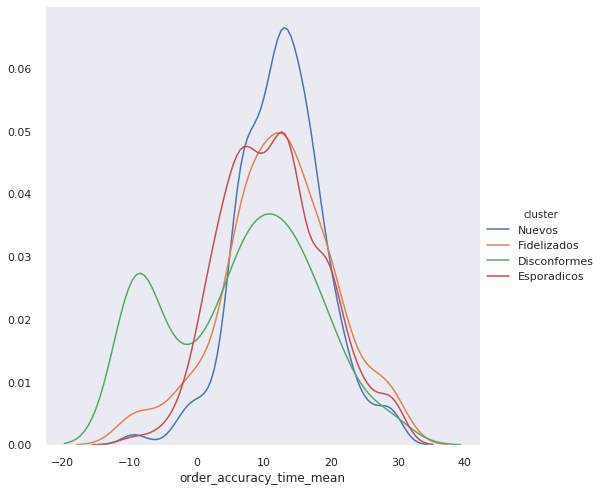

In [ ]:
# Numero de compras de los clientes en cada cluster

sns.FacetGrid(df_merged_sample, hue="cluster", height=7).map(sns.kdeplot, 'order_accuracy_time_mean').add_legend()


plt.show()

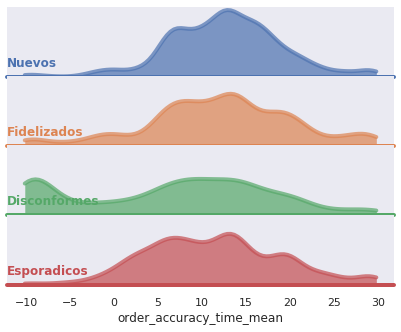

In [ ]:

ridge_plot = sns.FacetGrid(df_merged_sample, row="cluster", hue="cluster", aspect=5, height=1.25)

ridge_plot.map(sns.kdeplot, "order_accuracy_time_mean", clip_on=False, shade=True, alpha=0.7, lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "order_accuracy_time_mean")

ridge_plot.fig.subplots_adjust(hspace=-0.01)

ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)

### Longitud de descripcion del producto comprado

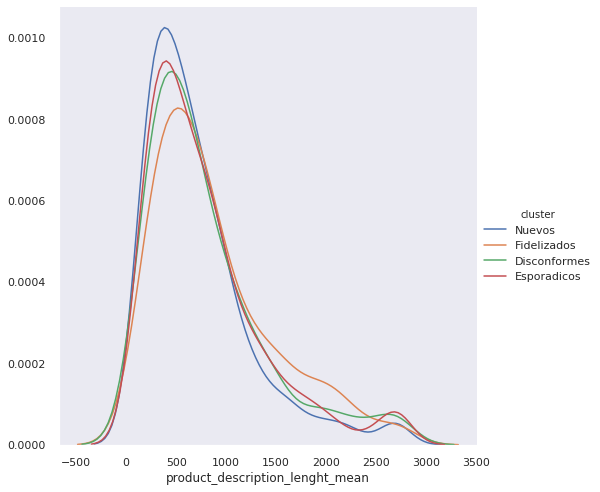

In [ ]:


sns.FacetGrid(df_merged_sample, hue="cluster", height=7).map(sns.kdeplot, 'product_description_lenght_mean').add_legend()


plt.show()

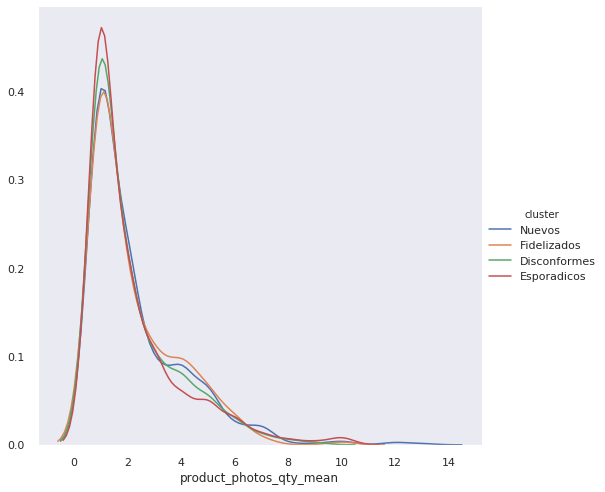

In [ ]:
sns.FacetGrid(df_merged_sample, hue="cluster", height=7).map(sns.kdeplot, 'product_photos_qty_mean').add_legend()


plt.show()

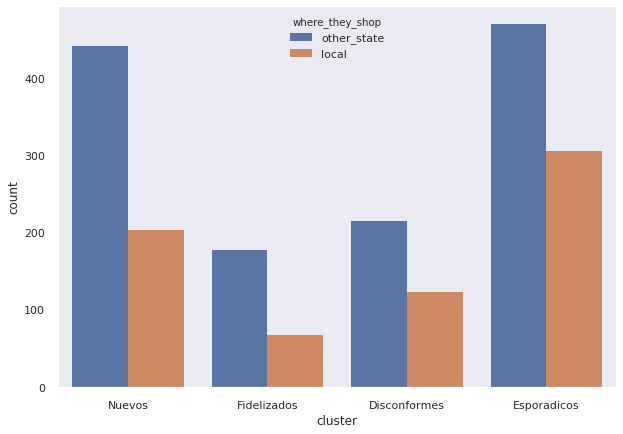

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x="cluster", hue="where_they_shop", data=df_merged_sample)
